# Introdução

Este caderno orienta o leitor através de uma implementação completa da arquitetura original do Neural Radiance Field, introduzida pela primeira vez por Mildenhall et al. em "[NeRF: Representando Cenas como Campos de Radiância Neural para Síntese de Visualização.](https://www.matthewtancik.com/nerf)" Para uma visão geral mais ampla, leia o artigo do Medium que acompanha "[It's NeRF From Nothing: Build A Complete NeRF com Pytorch.](https://medium.com/@masonmcgough/its-nerf-from-nothing-build-a-vanilla-nerf-with-pytorch-7846e4c45666)" Este caderno pressupõe que você leu esse artigo e entender os fundamentos do NeRF.

Grande parte do código vem ou é inspirado na implementação original do usuário do GitHub [bmild](https://github.com/bmild/nerf), bem como nas implementações do PyTorch dos usuários do GitHub [yenchenlin](https://github. com/bmild/nerf) e [krrish94](https://github.com/krrish94/nerf-pytorch/). O código foi modificado para maior clareza e consistência.

## Importar

In [1]:
import os
from typing import Optional, Tuple, List, Union, Callable

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from tqdm import trange

# For repeatability
# seed = 3407
# torch.manual_seed(seed)
# np.random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Entrada:

## Dados

Primeiro carregamos os dados nos quais treinaremos nosso modelo NeRF. Este é o trator Lego comumente visto nas demonstrações do NeRF e serve como uma espécie de “Olá Mundo” para o treinamento de NeRFs. Cobrir outros conjuntos de dados está fora do escopo deste caderno, mas sinta-se à vontade para experimentar outros incluídos no [código-fonte NeRF](https://github.com/bmild/nerf) original ou em seus próprios conjuntos de dados.

In [2]:
if not os.path.exists('tiny_nerf_data.npz'):
  !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

Este conjunto de dados consiste em 106 imagens tiradas do trator Lego sintético, juntamente com poses e um valor de distância focal comum. Assim como no original, reservamos as primeiras 100 imagens para treinamento e uma única imagem de teste para validação.

Images shape: (106, 100, 100, 3)
Poses shape: (106, 4, 4)
Focal length: 138.88887889922103
Pose
[[ 6.8935126e-01  5.3373039e-01 -4.8982298e-01 -1.9745398e+00]
 [-7.2442728e-01  5.0788772e-01 -4.6610624e-01 -1.8789345e+00]
 [ 1.4901163e-08  6.7615211e-01  7.3676193e-01  2.9699826e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


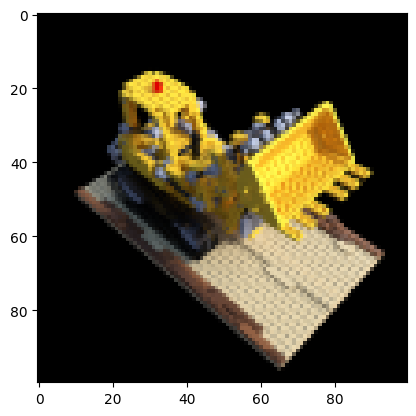

In [3]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']

print(f'Images shape: {images.shape}')
print(f'Poses shape: {poses.shape}')
print(f'Focal length: {focal}')

height, width = images.shape[1:3]
near, far = 2., 6.

n_training = 100
testimg_idx = 101
testimg, testpose = images[testimg_idx], poses[testimg_idx]

plt.imshow(testimg)
print('Pose')
print(testpose)

## Origens e direções

Lembre-se de que o NeRF processa entradas de um campo de posições (x,y,z) e visualização detalhada (θ,φ). Para reunir esses pontos de entrada, precisamos aplicar a renderização inversa às imagens de entrada. Mais concretamente, desenhamos linhas de projeção através de cada pixel e através do espaço 3D, a partir das quais podemos extrair amostras.

Para amostrar pontos do espaço 3D além da nossa imagem, primeiro começamos com a pose inicial de cada câmera tirada no conjunto de fotos. Com alguma matemática vetorial, podemos converter essas matrizes de pose 4x4 em uma coordenada 3D denotando a origem e um vetor 3D abaixo da direção. Os dois juntos descrevem um vetor que indica para onde a câmera estava apontando quando a foto foi tirada.

O código na célula abaixo ilustra isso desenhando setas que representam a origem e a direção de cada quadro.

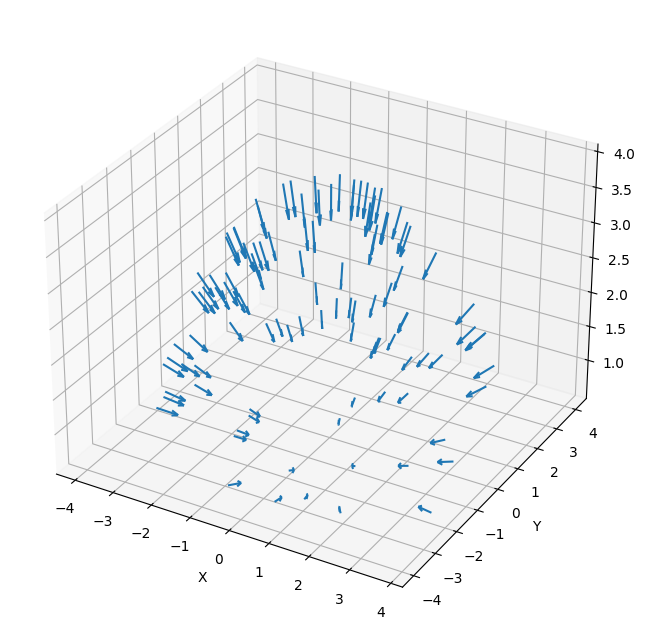

In [4]:
dirs = np.stack([np.sum([0, 0, -1] * pose[:3, :3], axis=-1) for pose in poses])
origins = poses[:, :3, -1]

ax = plt.figure(figsize=(12, 8)).add_subplot(projection='3d')
_ = ax.quiver(
  origins[..., 0].flatten(),
  origins[..., 1].flatten(),
  origins[..., 2].flatten(),
  dirs[..., 0].flatten(),
  dirs[..., 1].flatten(),
  dirs[..., 2].flatten(), length=0.5, normalize=True)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('z')
plt.show()

Com esta pose de câmera, podemos agora encontrar as linhas de projeção ao longo de cada pixel da nossa imagem. Cada linha é definida pelo seu ponto de origem (x,y,z) e pela sua direção (neste caso, um vetor 3D). Embora a origem seja a mesma para cada pixel, a direção é ligeiramente diferente. Essas linhas são ligeiramente desviadas do centro, de modo que nenhuma delas é paralela.

![Pinhole camera](https://www.researchgate.net/profile/Willy-Azarcoya-Cabiedes/publication/317498100/figure/fig10/AS:610418494013440@1522546518034/Pin-hole-camera-model-terminology-The-optical-center-pinhole-is-placed-at-the-origin.png)

De [Willy Azarcoya-Cabiedes via ResearchGate](https://www.researchgate.net/figure/Pin-hole-camera-model-terminology-The-optical-center-pinhole-is-placed-at-the-origin_fig10_317498100)

In [5]:
def get_rays(
  height: int,
  width: int,
  focal_length: float,
  c2w: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor]:
  r"""
  Find origin and direction of rays through every pixel and camera origin.
  """

  # Apply pinhole camera model to gather directions at each pixel
  i, j = torch.meshgrid(
      torch.arange(width, dtype=torch.float32).to(c2w),
      torch.arange(height, dtype=torch.float32).to(c2w),
      indexing='ij')
  i, j = i.transpose(-1, -2), j.transpose(-1, -2)
  directions = torch.stack([(i - width * .5) / focal_length,
                            -(j - height * .5) / focal_length,
                            -torch.ones_like(i)
                           ], dim=-1)

  # Apply camera pose to directions
  rays_d = torch.sum(directions[..., None, :] * c2w[:3, :3], dim=-1)

  # Origin is same for all directions (the optical center)
  rays_o = c2w[:3, -1].expand(rays_d.shape)
  return rays_o, rays_d

In [6]:
testpose

array([[ 6.8935126e-01,  5.3373039e-01, -4.8982298e-01, -1.9745398e+00],
       [-7.2442728e-01,  5.0788772e-01, -4.6610624e-01, -1.8789345e+00],
       [ 1.4901163e-08,  6.7615211e-01,  7.3676193e-01,  2.9699826e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],
      dtype=float32)

In [7]:
focal

array(138.8888789)

In [8]:
# Gather as torch tensors
images = torch.from_numpy(data['images'][:n_training]).to(device)
poses = torch.from_numpy(data['poses']).to(device)
focal = torch.from_numpy(data['focal']).to(device)
testimg = torch.from_numpy(data['images'][testimg_idx]).to(device)
testpose = torch.from_numpy(data['poses'][testimg_idx]).to(device)

# Grab rays from sample image
height, width = images.shape[1:3]
with torch.no_grad():
  ray_origin, ray_direction = get_rays(height, width, focal, testpose)

print('Ray Origin')
print(ray_origin.shape)
print(ray_origin[height // 2, width // 2, :])
print('')

print('Ray Direction')
print(ray_direction.shape)
print(ray_direction[height // 2, width // 2, :])
print('')

Ray Origin
torch.Size([100, 100, 3])
tensor([-1.9745, -1.8789,  2.9700], device='cuda:0')

Ray Direction
torch.Size([100, 100, 3])
tensor([ 0.4898,  0.4661, -0.7368], device='cuda:0')



# Arquiquetura

## Amostragem Estratificada

Agora que temos essas retas, definidas como vetores origem e direção, podemos iniciar o processo de amostragem delas. Lembre-se de que o NeRF adota uma estratégia de amostragem grosseira a fina, começando com a abordagem de amostragem estratificada.

A abordagem de amostragem estratificada divide o raio em caixas com espaçamento uniforme e amostra aleatoriamente dentro de cada caixa. A configuração `perturb` determina se os pontos devem ser amostrados uniformemente de cada compartimento ou simplesmente usar o centro do compartimento como ponto. Na maioria dos casos, queremos manter `perturb = True`, pois isso incentivará a rede a aprender em um espaço amostrado continuamente. Pode ser útil desabilitar para depuração.

In [9]:
def sample_stratified(
  rays_o: torch.Tensor,
  rays_d: torch.Tensor,
  near: float,
  far: float,
  n_samples: int,
  perturb: Optional[bool] = True,
  inverse_depth: bool = False
) -> Tuple[torch.Tensor, torch.Tensor]:
  r"""
  Sample along ray from regularly-spaced bins.
  """

  # Grab samples for space integration along ray
  t_vals = torch.linspace(0., 1., n_samples, device=rays_o.device)
  if not inverse_depth:
    # Sample linearly between `near` and `far`
    z_vals = near * (1.-t_vals) + far * (t_vals)
  else:
    # Sample linearly in inverse depth (disparity)
    z_vals = 1./(1./near * (1.-t_vals) + 1./far * (t_vals))

  # Draw uniform samples from bins along ray
  if perturb:
    mids = .5 * (z_vals[1:] + z_vals[:-1])
    upper = torch.concat([mids, z_vals[-1:]], dim=-1)
    lower = torch.concat([z_vals[:1], mids], dim=-1)
    t_rand = torch.rand([n_samples], device=z_vals.device)
    z_vals = lower + (upper - lower) * t_rand
  z_vals = z_vals.expand(list(rays_o.shape[:-1]) + [n_samples])

  # Apply scale from `rays_d` and offset from `rays_o` to samples
  # pts: (width, height, n_samples, 3)
  pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]
  return pts, z_vals

In [10]:
# Draw stratified samples from example
rays_o = ray_origin.view([-1, 3])
rays_d = ray_direction.view([-1, 3])
n_samples = 8
perturb = True
inverse_depth = False
with torch.no_grad():
  pts, z_vals = sample_stratified(rays_o, rays_d, near, far, n_samples,
                                  perturb=perturb, inverse_depth=inverse_depth)

print('Input Points')
print(pts.shape)
print('')
print('Distances Along Ray')
print(z_vals.shape)

Input Points
torch.Size([10000, 8, 3])

Distances Along Ray
torch.Size([10000, 8])


Agora visualizamos esses pontos amostrados. Os pontos azuis imperturbados são os "centros" dos compartimentos. Os pontos vermelhos são uma amostragem de pontos perturbados. Observe como os pontos vermelhos estão ligeiramente deslocados dos pontos azuis acima deles, mas todos estão restritos entre `próximo` e `distante`.

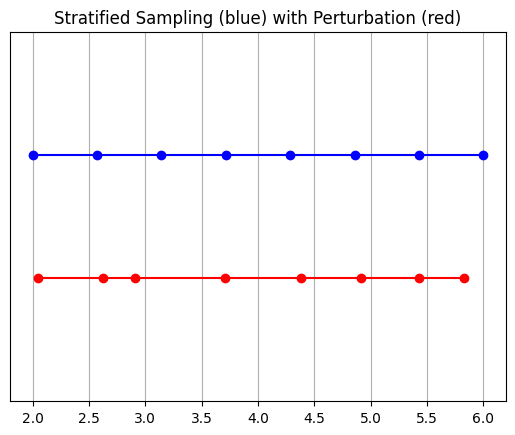

In [11]:
y_vals = torch.zeros_like(z_vals)

_, z_vals_unperturbed = sample_stratified(rays_o, rays_d, near, far, n_samples,
                                  perturb=False, inverse_depth=inverse_depth)
plt.plot(z_vals_unperturbed[0].cpu().numpy(), 1 + y_vals[0].cpu().numpy(), 'b-o')
plt.plot(z_vals[0].cpu().numpy(), y_vals[0].cpu().numpy(), 'r-o')
plt.ylim([-1, 2])
plt.title('Stratified Sampling (blue) with Perturbation (red)')
ax = plt.gca()
ax.axes.yaxis.set_visible(False)
plt.grid(True)

## Codificador posicional

Assim como os Transformers, os NeRFs fazem uso de codificadores posicionais. Nesse caso, é para mapear as entradas para um espaço de frequência mais alta para compensar o viés que as redes neurais têm para aprender funções de frequência mais baixa.

Aqui construímos um simples `torch.nn.Module` do nosso codificador posicional. A mesma implementação do codificador pode ser aplicada a amostras de entrada e direções de visualização. No entanto, escolhemos parâmetros diferentes para essas entradas. Usamos as configurações padrão do original.

In [12]:
class PositionalEncoder(nn.Module):
  r"""
  Sine-cosine positional encoder for input points.
  """
  def __init__(
    self,
    d_input: int,
    n_freqs: int,
    log_space: bool = False
  ):
    super().__init__()
    self.d_input = d_input
    self.n_freqs = n_freqs
    self.log_space = log_space
    self.d_output = d_input * (1 + 2 * self.n_freqs)
    self.embed_fns = [lambda x: x]

    # Define frequencies in either linear or log scale
    if self.log_space:
      freq_bands = 2.**torch.linspace(0., self.n_freqs - 1, self.n_freqs)
    else:
      freq_bands = torch.linspace(2.**0., 2.**(self.n_freqs - 1), self.n_freqs)

    # Alternate sin and cos
    for freq in freq_bands:
      self.embed_fns.append(lambda x, freq=freq: torch.sin(x * freq))
      self.embed_fns.append(lambda x, freq=freq: torch.cos(x * freq))

  def forward(
    self,
    x
  ) -> torch.Tensor:
    r"""
    Apply positional encoding to input.
    """
    return torch.concat([fn(x) for fn in self.embed_fns], dim=-1)


In [13]:
# Create encoders for points and view directions
encoder = PositionalEncoder(3, 10)
viewdirs_encoder = PositionalEncoder(3, 4)

# Grab flattened points and view directions
pts_flattened = pts.reshape(-1, 3)
viewdirs = rays_d / torch.norm(rays_d, dim=-1, keepdim=True)
flattened_viewdirs = viewdirs[:, None, ...].expand(pts.shape).reshape((-1, 3))

# Encode inputs
encoded_points = encoder(pts_flattened)
encoded_viewdirs = viewdirs_encoder(flattened_viewdirs)

print('Encoded Points')
print(encoded_points.shape)
print(torch.min(encoded_points), torch.max(encoded_points), torch.mean(encoded_points))
print('')

print(encoded_viewdirs.shape)
print('Encoded Viewdirs')
print(torch.min(encoded_viewdirs), torch.max(encoded_viewdirs), torch.mean(encoded_viewdirs))
print('')

Encoded Points
torch.Size([80000, 63])
tensor(-2.7154, device='cuda:0') tensor(3.4242, device='cuda:0') tensor(0.0256, device='cuda:0')

torch.Size([80000, 27])
Encoded Viewdirs
tensor(-1., device='cuda:0') tensor(1., device='cuda:0') tensor(0.1056, device='cuda:0')



## Modelo NeRF

Aqui definimos o modelo NeRF, que consiste principalmente em uma `ModuleList` de camadas `Lineares`, separadas por funções de ativação não lineares e conexões residuais ocasionais. Este modelo apresenta uma entrada opcional para direções de visualização, que alterará a arquitetura do modelo se fornecida na instanciação. Esta implementação é baseada na Seção 3 do artigo original "NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis" e usa os mesmos padrões.

In [14]:
class NeRF(nn.Module):
  r"""
  Neural radiance fields module.
  """
  def __init__(
    self,
    d_input: int = 3,
    n_layers: int = 8,
    d_filter: int = 256,
    skip: Tuple[int] = (4,),
    d_viewdirs: Optional[int] = None
  ):
    super().__init__()
    self.d_input = d_input
    self.skip = skip
    self.act = nn.functional.relu
    self.d_viewdirs = d_viewdirs

    # Create model layers
    self.layers = nn.ModuleList(
      [nn.Linear(self.d_input, d_filter)] +
      [nn.Linear(d_filter + self.d_input, d_filter) if i in skip \
       else nn.Linear(d_filter, d_filter) for i in range(n_layers - 1)]
    )

    # Bottleneck layers
    if self.d_viewdirs is not None:
      # If using viewdirs, split alpha and RGB
      self.alpha_out = nn.Linear(d_filter, 1)
      self.rgb_filters = nn.Linear(d_filter, d_filter)
      self.branch = nn.Linear(d_filter + self.d_viewdirs, d_filter // 2)
      self.output = nn.Linear(d_filter // 2, 3)
    else:
      # If no viewdirs, use simpler output
      self.output = nn.Linear(d_filter, 4)

  def forward(
    self,
    x: torch.Tensor,
    viewdirs: Optional[torch.Tensor] = None
  ) -> torch.Tensor:
    r"""
    Forward pass with optional view direction.
    """

    # Cannot use viewdirs if instantiated with d_viewdirs = None
    if self.d_viewdirs is None and viewdirs is not None:
      raise ValueError('Cannot input x_direction if d_viewdirs was not given.')

    # Apply forward pass up to bottleneck
    x_input = x
    for i, layer in enumerate(self.layers):
      x = self.act(layer(x))
      if i in self.skip:
        x = torch.cat([x, x_input], dim=-1)

    # Apply bottleneck
    if self.d_viewdirs is not None:
      # Split alpha from network output
      alpha = self.alpha_out(x)

      # Pass through bottleneck to get RGB
      x = self.rgb_filters(x)
      x = torch.concat([x, viewdirs], dim=-1)
      x = self.act(self.branch(x))
      x = self.output(x)

      # Concatenate alphas to output
      x = torch.concat([x, alpha], dim=-1)
    else:
      # Simple output
      x = self.output(x)
    return x

## Renderização de volume

A partir das saídas brutas do NeRF, ainda precisamos convertê-las em uma imagem. É aqui que aplicamos a integração de volume descrita nas Equações 1-3 na Seção 4 do artigo. Essencialmente, pegamos a soma ponderada de todas as amostras ao longo do raio de cada pixel para obter o valor estimado da cor naquele pixel. Cada amostra RGB é ponderada pelo seu valor alfa. Valores alfa mais altos indicam maior probabilidade de a área amostrada ser opaca, portanto, pontos mais ao longo do raio têm maior probabilidade de serem ocluídos. O produto cumulativo garante que esses pontos adicionais sejam amortecidos.

In [15]:
def cumprod_exclusive(
  tensor: torch.Tensor
) -> torch.Tensor:
  r"""
  (Courtesy of https://github.com/krrish94/nerf-pytorch)

  Mimick functionality of tf.math.cumprod(..., exclusive=True), as it isn't available in PyTorch.

  Args:
  tensor (torch.Tensor): Tensor whose cumprod (cumulative product, see `torch.cumprod`) along dim=-1
    is to be computed.
  Returns:
  cumprod (torch.Tensor): cumprod of Tensor along dim=-1, mimiciking the functionality of
    tf.math.cumprod(..., exclusive=True) (see `tf.math.cumprod` for details).
  """

  # Compute regular cumprod first (this is equivalent to `tf.math.cumprod(..., exclusive=False)`).
  cumprod = torch.cumprod(tensor, -1)
  # "Roll" the elements along dimension 'dim' by 1 element.
  cumprod = torch.roll(cumprod, 1, -1)
  # Replace the first element by "1" as this is what tf.cumprod(..., exclusive=True) does.
  cumprod[..., 0] = 1.

  return cumprod

def raw2outputs(
  raw: torch.Tensor,
  z_vals: torch.Tensor,
  rays_d: torch.Tensor,
  raw_noise_std: float = 0.0,
  white_bkgd: bool = False
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
  r"""
  Convert the raw NeRF output into RGB and other maps.
  """

  # Difference between consecutive elements of `z_vals`. [n_rays, n_samples]
  dists = z_vals[..., 1:] - z_vals[..., :-1]
  dists = torch.cat([dists, 1e10 * torch.ones_like(dists[..., :1])], dim=-1)

  # Multiply each distance by the norm of its corresponding direction ray
  # to convert to real world distance (accounts for non-unit directions).
  dists = dists * torch.norm(rays_d[..., None, :], dim=-1)

  # Add noise to model's predictions for density. Can be used to
  # regularize network during training (prevents floater artifacts).
  noise = 0.
  if raw_noise_std > 0.:
    noise = torch.randn(raw[..., 3].shape) * raw_noise_std

  # Predict density of each sample along each ray. Higher values imply
  # higher likelihood of being absorbed at this point. [n_rays, n_samples]
  alpha = 1.0 - torch.exp(-nn.functional.relu(raw[..., 3] + noise) * dists)

  # Compute weight for RGB of each sample along each ray. [n_rays, n_samples]
  # The higher the alpha, the lower subsequent weights are driven.
  weights = alpha * cumprod_exclusive(1. - alpha + 1e-10)

  # Compute weighted RGB map.
  rgb = torch.sigmoid(raw[..., :3])  # [n_rays, n_samples, 3]
  rgb_map = torch.sum(weights[..., None] * rgb, dim=-2)  # [n_rays, 3]

  # Estimated depth map is predicted distance.
  depth_map = torch.sum(weights * z_vals, dim=-1)

  # Disparity map is inverse depth.
  disp_map = 1. / torch.max(1e-10 * torch.ones_like(depth_map),
                            depth_map / torch.sum(weights, -1))

  # Sum of weights along each ray. In [0, 1] up to numerical error.
  acc_map = torch.sum(weights, dim=-1)

  # To composite onto a white background, use the accumulated alpha map.
  if white_bkgd:
    rgb_map = rgb_map + (1. - acc_map[..., None])

  return rgb_map, depth_map, acc_map, weights

## Amostragem hierárquica de volume

O espaço 3D é de fato muito escasso com oclusões e por isso a maioria dos pontos não contribui muito para a imagem renderizada. Portanto, é mais benéfico sobreamostrar regiões com alta probabilidade de contribuir para a integral. Aqui aplicamos pesos aprendidos e normalizados ao primeiro conjunto de amostras para criar um PDF através do raio e, em seguida, aplicamos amostragem de transformada inversa a este PDF para reunir um segundo conjunto de amostras.

In [16]:
def sample_pdf(
  bins: torch.Tensor,
  weights: torch.Tensor,
  n_samples: int,
  perturb: bool = False
) -> torch.Tensor:
  r"""
  Apply inverse transform sampling to a weighted set of points.
  """

  # Normalize weights to get PDF.
  pdf = (weights + 1e-5) / torch.sum(weights + 1e-5, -1, keepdims=True) # [n_rays, weights.shape[-1]]

  # Convert PDF to CDF.
  cdf = torch.cumsum(pdf, dim=-1) # [n_rays, weights.shape[-1]]
  cdf = torch.concat([torch.zeros_like(cdf[..., :1]), cdf], dim=-1) # [n_rays, weights.shape[-1] + 1]

  # Take sample positions to grab from CDF. Linear when perturb == 0.
  if not perturb:
    u = torch.linspace(0., 1., n_samples, device=cdf.device)
    u = u.expand(list(cdf.shape[:-1]) + [n_samples]) # [n_rays, n_samples]
  else:
    u = torch.rand(list(cdf.shape[:-1]) + [n_samples], device=cdf.device) # [n_rays, n_samples]

  # Find indices along CDF where values in u would be placed.
  u = u.contiguous() # Returns contiguous tensor with same values.
  inds = torch.searchsorted(cdf, u, right=True) # [n_rays, n_samples]

  # Clamp indices that are out of bounds.
  below = torch.clamp(inds - 1, min=0)
  above = torch.clamp(inds, max=cdf.shape[-1] - 1)
  inds_g = torch.stack([below, above], dim=-1) # [n_rays, n_samples, 2]

  # Sample from cdf and the corresponding bin centers.
  matched_shape = list(inds_g.shape[:-1]) + [cdf.shape[-1]]
  cdf_g = torch.gather(cdf.unsqueeze(-2).expand(matched_shape), dim=-1,
                       index=inds_g)
  bins_g = torch.gather(bins.unsqueeze(-2).expand(matched_shape), dim=-1,
                        index=inds_g)

  # Convert samples to ray length.
  denom = (cdf_g[..., 1] - cdf_g[..., 0])
  denom = torch.where(denom < 1e-5, torch.ones_like(denom), denom)
  t = (u - cdf_g[..., 0]) / denom
  samples = bins_g[..., 0] + t * (bins_g[..., 1] - bins_g[..., 0])

  return samples # [n_rays, n_samples]

In [17]:
def sample_hierarchical(
  rays_o: torch.Tensor,
  rays_d: torch.Tensor,
  z_vals: torch.Tensor,
  weights: torch.Tensor,
  n_samples: int,
  perturb: bool = False
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
  r"""
  Apply hierarchical sampling to the rays.
  """

  # Draw samples from PDF using z_vals as bins and weights as probabilities.
  z_vals_mid = .5 * (z_vals[..., 1:] + z_vals[..., :-1])
  new_z_samples = sample_pdf(z_vals_mid, weights[..., 1:-1], n_samples,
                          perturb=perturb)
  new_z_samples = new_z_samples.detach()

  # Resample points from ray based on PDF.
  z_vals_combined, _ = torch.sort(torch.cat([z_vals, new_z_samples], dim=-1), dim=-1)
  pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals_combined[..., :, None]  # [N_rays, N_samples + n_samples, 3]
  return pts, z_vals_combined, new_z_samples

## Passe para frente completo

É aqui que juntamos tudo para calcular uma única passagem direta em nosso modelo.

Devido a possíveis problemas de memória, a passagem direta é calculada em "blocos", que são então agregados em um único lote. A propagação do gradiente é feita após todo o lote ser processado, daí a distinção entre "pedaços" e "lotes". O chunking é especialmente importante para o ambiente Google Colab, que fornece recursos mais modestos do que os citados no artigo original.

In [18]:
def get_chunks(
  inputs: torch.Tensor,
  chunksize: int = 2**15
) -> List[torch.Tensor]:
  r"""
  Divide an input into chunks.
  """
  return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]

def prepare_chunks(
  points: torch.Tensor,
  encoding_function: Callable[[torch.Tensor], torch.Tensor],
  chunksize: int = 2**15
) -> List[torch.Tensor]:
  r"""
  Encode and chunkify points to prepare for NeRF model.
  """
  points = points.reshape((-1, 3))
  points = encoding_function(points)
  points = get_chunks(points, chunksize=chunksize)
  return points

def prepare_viewdirs_chunks(
  points: torch.Tensor,
  rays_d: torch.Tensor,
  encoding_function: Callable[[torch.Tensor], torch.Tensor],
  chunksize: int = 2**15
) -> List[torch.Tensor]:
  r"""
  Encode and chunkify viewdirs to prepare for NeRF model.
  """
  # Prepare the viewdirs
  viewdirs = rays_d / torch.norm(rays_d, dim=-1, keepdim=True)
  viewdirs = viewdirs[:, None, ...].expand(points.shape).reshape((-1, 3))
  viewdirs = encoding_function(viewdirs)
  viewdirs = get_chunks(viewdirs, chunksize=chunksize)
  return viewdirs

In [19]:
def nerf_forward(
  rays_o: torch.Tensor,
  rays_d: torch.Tensor,
  near: float,
  far: float,
  encoding_fn: Callable[[torch.Tensor], torch.Tensor],
  coarse_model: nn.Module,
  kwargs_sample_stratified: dict = None,
  n_samples_hierarchical: int = 0,
  kwargs_sample_hierarchical: dict = None,
  fine_model = None,
  viewdirs_encoding_fn: Optional[Callable[[torch.Tensor], torch.Tensor]] = None,
  chunksize: int = 2**15
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, dict]:
  r"""
  Compute forward pass through model(s).
  """

  # Set no kwargs if none are given.
  if kwargs_sample_stratified is None:
    kwargs_sample_stratified = {}
  if kwargs_sample_hierarchical is None:
    kwargs_sample_hierarchical = {}

  # Sample query points along each ray.
  query_points, z_vals = sample_stratified(
      rays_o, rays_d, near, far, **kwargs_sample_stratified)

  # Prepare batches.
  batches = prepare_chunks(query_points, encoding_fn, chunksize=chunksize)
  if viewdirs_encoding_fn is not None:
    batches_viewdirs = prepare_viewdirs_chunks(query_points, rays_d,
                                               viewdirs_encoding_fn,
                                               chunksize=chunksize)
  else:
    batches_viewdirs = [None] * len(batches)

  # Coarse model pass.
  # Split the encoded points into "chunks", run the model on all chunks, and
  # concatenate the results (to avoid out-of-memory issues).
  predictions = []
  for batch, batch_viewdirs in zip(batches, batches_viewdirs):
    predictions.append(coarse_model(batch, viewdirs=batch_viewdirs))
  raw = torch.cat(predictions, dim=0)
  raw = raw.reshape(list(query_points.shape[:2]) + [raw.shape[-1]])

  # Perform differentiable volume rendering to re-synthesize the RGB image.
  rgb_map, depth_map, acc_map, weights = raw2outputs(raw, z_vals, rays_d)
  # rgb_map, depth_map, acc_map, weights = render_volume_density(raw, rays_o, z_vals)
  outputs = {
      'z_vals_stratified': z_vals
  }

  # Fine model pass.
  if n_samples_hierarchical > 0:
    # Save previous outputs to return.
    rgb_map_0, depth_map_0, acc_map_0 = rgb_map, depth_map, acc_map

    # Apply hierarchical sampling for fine query points.
    query_points, z_vals_combined, z_hierarch = sample_hierarchical(
      rays_o, rays_d, z_vals, weights, n_samples_hierarchical,
      **kwargs_sample_hierarchical)

    # Prepare inputs as before.
    batches = prepare_chunks(query_points, encoding_fn, chunksize=chunksize)
    if viewdirs_encoding_fn is not None:
      batches_viewdirs = prepare_viewdirs_chunks(query_points, rays_d,
                                                 viewdirs_encoding_fn,
                                                 chunksize=chunksize)
    else:
      batches_viewdirs = [None] * len(batches)

    # Forward pass new samples through fine model.
    fine_model = fine_model if fine_model is not None else coarse_model
    predictions = []
    for batch, batch_viewdirs in zip(batches, batches_viewdirs):
      predictions.append(fine_model(batch, viewdirs=batch_viewdirs))
    raw = torch.cat(predictions, dim=0)
    raw = raw.reshape(list(query_points.shape[:2]) + [raw.shape[-1]])

    # Perform differentiable volume rendering to re-synthesize the RGB image.
    rgb_map, depth_map, acc_map, weights = raw2outputs(raw, z_vals_combined, rays_d)

    # Store outputs.
    outputs['z_vals_hierarchical'] = z_hierarch
    outputs['rgb_map_0'] = rgb_map_0
    outputs['depth_map_0'] = depth_map_0
    outputs['acc_map_0'] = acc_map_0

  # Store outputs.
  outputs['rgb_map'] = rgb_map
  outputs['depth_map'] = depth_map
  outputs['acc_map'] = acc_map
  outputs['weights'] = weights
  return outputs

# Treinamento

Finalmente, temos (quase) tudo que precisamos para treinar o modelo. Agora faremos algumas configurações para um procedimento de treinamento simples, criando hiperparâmetros e funções auxiliares e, em seguida, treinaremos nosso modelo.

## Hiperparâmetros

Todos os hiperparâmetros de treinamento são definidos aqui. Os padrões foram retirados do original, a menos que restrições computacionais os proíbam. Nesse caso, aplicamos padrões sensatos que estão dentro dos recursos fornecidos pelo Google Colab.

In [20]:
# Encoders
d_input = 3           # Number of input dimensions
n_freqs = 10          # Number of encoding functions for samples
log_space = True      # If set, frequencies scale in log space
use_viewdirs = True   # If set, use view direction as input
n_freqs_views = 4     # Number of encoding functions for views

# Stratified sampling
n_samples = 64         # Number of spatial samples per ray
perturb = True         # If set, applies noise to sample positions
inverse_depth = False  # If set, samples points linearly in inverse depth

# Model
d_filter = 128          # Dimensions of linear layer filters
n_layers = 2            # Number of layers in network bottleneck
skip = []               # Layers at which to apply input residual
use_fine_model = True   # If set, creates a fine model
d_filter_fine = 128     # Dimensions of linear layer filters of fine network
n_layers_fine = 6       # Number of layers in fine network bottleneck

# Hierarchical sampling
n_samples_hierarchical = 64   # Number of samples per ray
perturb_hierarchical = False  # If set, applies noise to sample positions

# Optimizer
lr = 5e-4  # Learning rate

# Training
n_iters = 10000
batch_size = 2**14          # Number of rays per gradient step (power of 2)
one_image_per_step = True   # One image per gradient step (disables batching)
chunksize = 2**14           # Modify as needed to fit in GPU memory
center_crop = True          # Crop the center of image (one_image_per_)
center_crop_iters = 50      # Stop cropping center after this many epochs
display_rate = 25          # Display test output every X epochs

# Early Stopping
warmup_iters = 100          # Number of iterations during warmup phase
warmup_min_fitness = 10.0   # Min val PSNR to continue training at warmup_iters
n_restarts = 10             # Number of times to restart if training stalls

# We bundle the kwargs for various functions to pass all at once.
kwargs_sample_stratified = {
    'n_samples': n_samples,
    'perturb': perturb,
    'inverse_depth': inverse_depth
}
kwargs_sample_hierarchical = {
    'perturb': perturb
}

## Classes e funções de treinamento

Aqui criamos algumas funções auxiliares para treinamento. O NeRF pode estar sujeito a mínimos locais, nos quais o treinamento irá rapidamente parar e produzir resultados em branco. `EarlyStopping` é usado para reiniciar o treinamento quando o aprendizado para, se necessário.

In [21]:
def plot_samples(
  z_vals: torch.Tensor,
  z_hierarch: Optional[torch.Tensor] = None,
  ax: Optional[np.ndarray] = None):
  r"""
  Plot stratified and (optional) hierarchical samples.
  """
  y_vals = 1 + np.zeros_like(z_vals)

  if ax is None:
    ax = plt.subplot()
  ax.plot(z_vals, y_vals, 'b-o')
  if z_hierarch is not None:
    y_hierarch = np.zeros_like(z_hierarch)
    ax.plot(z_hierarch, y_hierarch, 'r-o')
  ax.set_ylim([-1, 2])
  ax.set_title('Stratified  Samples (blue) and Hierarchical Samples (red)')
  ax.axes.yaxis.set_visible(False)
  ax.grid(True)
  return ax

def crop_center(
  img: torch.Tensor,
  frac: float = 0.5
) -> torch.Tensor:
  r"""
  Crop center square from image.
  """
  h_offset = round(img.shape[0] * (frac / 2))
  w_offset = round(img.shape[1] * (frac / 2))
  return img[h_offset:-h_offset, w_offset:-w_offset]

class EarlyStopping:
  r"""
  Early stopping helper based on fitness criterion.
  """
  def __init__(
    self,
    patience: int = 30,
    margin: float = 1e-4
  ):
    self.best_fitness = 0.0  # In our case PSNR
    self.best_iter = 0
    self.margin = margin
    self.patience = patience or float('inf')  # epochs to wait after fitness stops improving to stop

  def __call__(
    self,
    iter: int,
    fitness: float
  ):
    r"""
    Check if criterion for stopping is met.
    """
    if (fitness - self.best_fitness) > self.margin:
      self.best_iter = iter
      self.best_fitness = fitness
    delta = iter - self.best_iter
    stop = delta >= self.patience  # stop training if patience exceeded
    return stop

In [22]:
def init_models():
  r"""
  Initialize models, encoders, and optimizer for NeRF training.
  """
  # Encoders
  encoder = PositionalEncoder(d_input, n_freqs, log_space=log_space)
  encode = lambda x: encoder(x)

  # View direction encoders
  if use_viewdirs:
    encoder_viewdirs = PositionalEncoder(d_input, n_freqs_views,
                                        log_space=log_space)
    encode_viewdirs = lambda x: encoder_viewdirs(x)
    d_viewdirs = encoder_viewdirs.d_output
  else:
    encode_viewdirs = None
    d_viewdirs = None

  # Models
  model = NeRF(encoder.d_output, n_layers=n_layers, d_filter=d_filter, skip=skip,
              d_viewdirs=d_viewdirs)
  model.to(device)
  model_params = list(model.parameters())
  if use_fine_model:
    fine_model = NeRF(encoder.d_output, n_layers=n_layers, d_filter=d_filter, skip=skip,
                      d_viewdirs=d_viewdirs)
    fine_model.to(device)
    model_params = model_params + list(fine_model.parameters())
  else:
    fine_model = None

  # Optimizer
  optimizer = torch.optim.Adam(model_params, lr=lr)

  # Early Stopping
  warmup_stopper = EarlyStopping(patience=50)

  return model, fine_model, encode, encode_viewdirs, optimizer, warmup_stopper

## Ciclo de treinamento

Aqui começamos a treinar nosso modelo.

In [23]:
def train():
  r"""
  Launch training session for NeRF.
  """
  # Shuffle rays across all images.
  if not one_image_per_step:
    height, width = images.shape[1:3]
    all_rays = torch.stack([torch.stack(get_rays(height, width, focal, p), 0)
                        for p in poses[:n_training]], 0)
    rays_rgb = torch.cat([all_rays, images[:, None]], 1)
    rays_rgb = torch.permute(rays_rgb, [0, 2, 3, 1, 4])
    rays_rgb = rays_rgb.reshape([-1, 3, 3])
    rays_rgb = rays_rgb.type(torch.float32)
    rays_rgb = rays_rgb[torch.randperm(rays_rgb.shape[0])]
    i_batch = 0

  train_psnrs = []
  val_psnrs = []
  iternums = []
  for i in trange(n_iters):
    model.train()

    if one_image_per_step:
      # Randomly pick an image as the target.
      target_img_idx = np.random.randint(images.shape[0])
      target_img = images[target_img_idx].to(device)
      if center_crop and i < center_crop_iters:
        target_img = crop_center(target_img)
      height, width = target_img.shape[:2]
      target_pose = poses[target_img_idx].to(device)
      rays_o, rays_d = get_rays(height, width, focal, target_pose)
      rays_o = rays_o.reshape([-1, 3])
      rays_d = rays_d.reshape([-1, 3])
    else:
      # Random over all images.
      batch = rays_rgb[i_batch:i_batch + batch_size]
      batch = torch.transpose(batch, 0, 1)
      rays_o, rays_d, target_img = batch
      height, width = target_img.shape[:2]
      i_batch += batch_size
      # Shuffle after one epoch
      if i_batch >= rays_rgb.shape[0]:
          rays_rgb = rays_rgb[torch.randperm(rays_rgb.shape[0])]
          i_batch = 0
    target_img = target_img.reshape([-1, 3])

    # Run one iteration of TinyNeRF and get the rendered RGB image.
    outputs = nerf_forward(rays_o, rays_d,
                           near, far, encode, model,
                           kwargs_sample_stratified=kwargs_sample_stratified,
                           n_samples_hierarchical=n_samples_hierarchical,
                           kwargs_sample_hierarchical=kwargs_sample_hierarchical,
                           fine_model=fine_model,
                           viewdirs_encoding_fn=encode_viewdirs,
                           chunksize=chunksize)

    # Check for any numerical issues.
    for k, v in outputs.items():
      if torch.isnan(v).any():
        print(f"! [Numerical Alert] {k} contains NaN.")
      if torch.isinf(v).any():
        print(f"! [Numerical Alert] {k} contains Inf.")

    # Backprop!
    rgb_predicted = outputs['rgb_map']
    loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    psnr = -10. * torch.log10(loss)
    train_psnrs.append(psnr.item())

    # Evaluate testimg at given display rate.
    if i % display_rate == 0:
      model.eval()
      height, width = testimg.shape[:2]
      rays_o, rays_d = get_rays(height, width, focal, testpose)
      rays_o = rays_o.reshape([-1, 3])
      rays_d = rays_d.reshape([-1, 3])
      outputs = nerf_forward(rays_o, rays_d,
                             near, far, encode, model,
                             kwargs_sample_stratified=kwargs_sample_stratified,
                             n_samples_hierarchical=n_samples_hierarchical,
                             kwargs_sample_hierarchical=kwargs_sample_hierarchical,
                             fine_model=fine_model,
                             viewdirs_encoding_fn=encode_viewdirs,
                             chunksize=chunksize)

      rgb_predicted = outputs['rgb_map']
      loss = torch.nn.functional.mse_loss(rgb_predicted, testimg.reshape(-1, 3))
      print("Loss:", loss.item())
      val_psnr = -10. * torch.log10(loss)
      val_psnrs.append(val_psnr.item())
      iternums.append(i)

      # Plot example outputs
      fig, ax = plt.subplots(1, 4, figsize=(24,4), gridspec_kw={'width_ratios': [1, 1, 1, 3]})
      ax[0].imshow(rgb_predicted.reshape([height, width, 3]).detach().cpu().numpy())
      ax[0].set_title(f'Iteration: {i}')
      ax[1].imshow(testimg.detach().cpu().numpy())
      ax[1].set_title(f'Target')
      ax[2].plot(range(0, i + 1), train_psnrs, 'r')
      ax[2].plot(iternums, val_psnrs, 'b')
      ax[2].set_title('PSNR (train=red, val=blue')
      z_vals_strat = outputs['z_vals_stratified'].view((-1, n_samples))
      z_sample_strat = z_vals_strat[z_vals_strat.shape[0] // 2].detach().cpu().numpy()
      if 'z_vals_hierarchical' in outputs:
        z_vals_hierarch = outputs['z_vals_hierarchical'].view((-1, n_samples_hierarchical))
        z_sample_hierarch = z_vals_hierarch[z_vals_hierarch.shape[0] // 2].detach().cpu().numpy()
      else:
        z_sample_hierarch = None
      _ = plot_samples(z_sample_strat, z_sample_hierarch, ax=ax[3])
      ax[3].margins(0)
      plt.show()

    # Check PSNR for issues and stop if any are found.
    if i == warmup_iters - 1:
      if val_psnr < warmup_min_fitness:
        print(f'Val PSNR {val_psnr} below warmup_min_fitness {warmup_min_fitness}. Stopping...')
        return False, train_psnrs, val_psnrs
    elif i < warmup_iters:
      if warmup_stopper is not None and warmup_stopper(i, psnr):
        print(f'Train PSNR flatlined at {psnr} for {warmup_stopper.patience} iters. Stopping...')
        return False, train_psnrs, val_psnrs

  return True, train_psnrs, val_psnrs

  0%|          | 0/10000 [00:00<?, ?it/s]

Loss: 0.13519106805324554


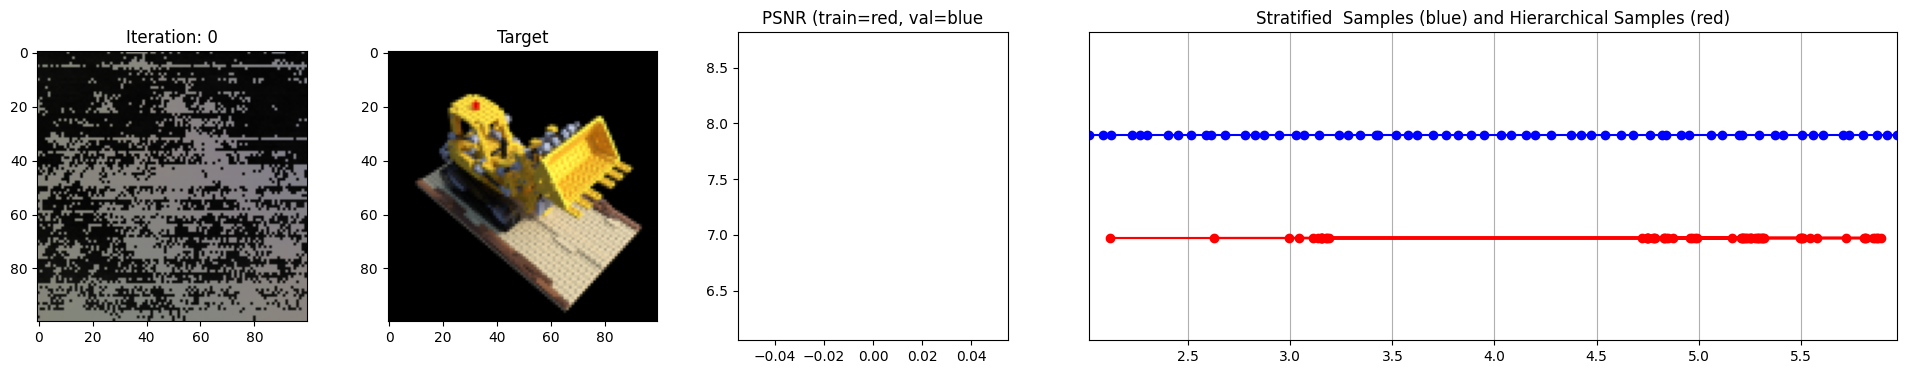

  0%|          | 25/10000 [00:04<22:42,  7.32it/s]

Loss: 0.1332968771457672


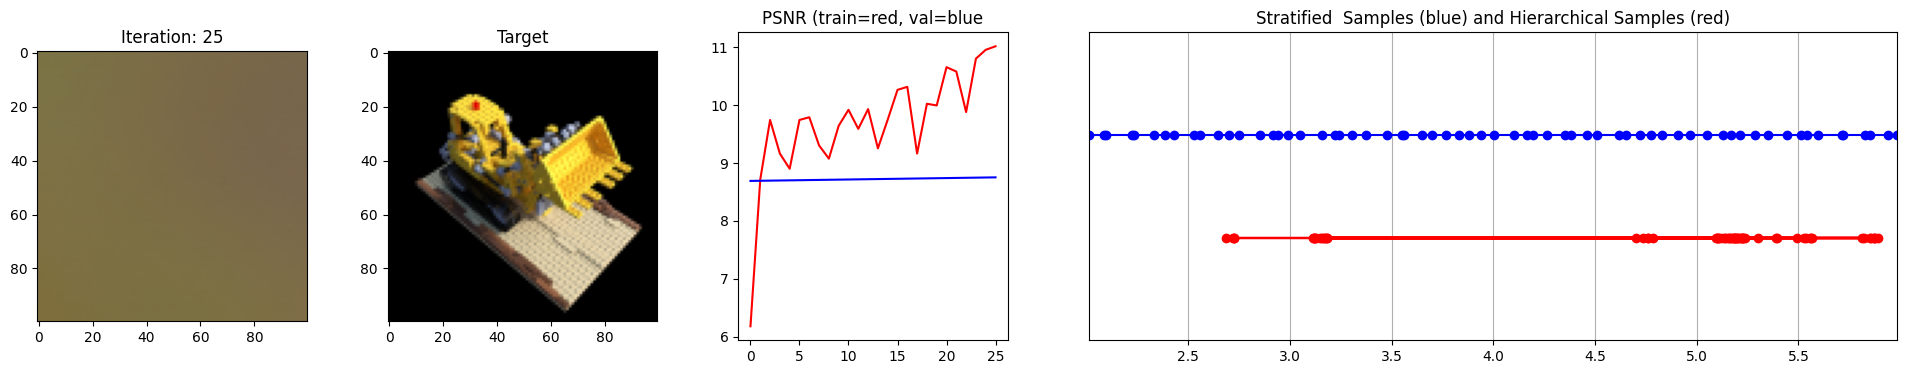

  0%|          | 50/10000 [00:08<20:28,  8.10it/s]

Loss: 0.11385731399059296


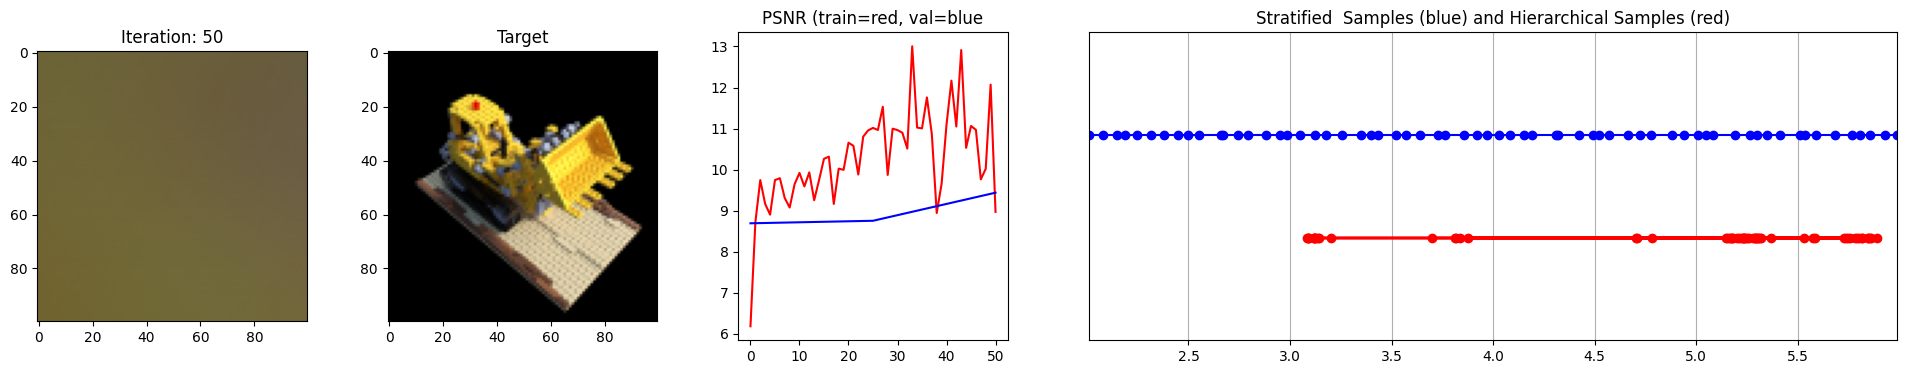

  1%|          | 75/10000 [00:22<1:11:38,  2.31it/s]

Loss: 0.08540444076061249


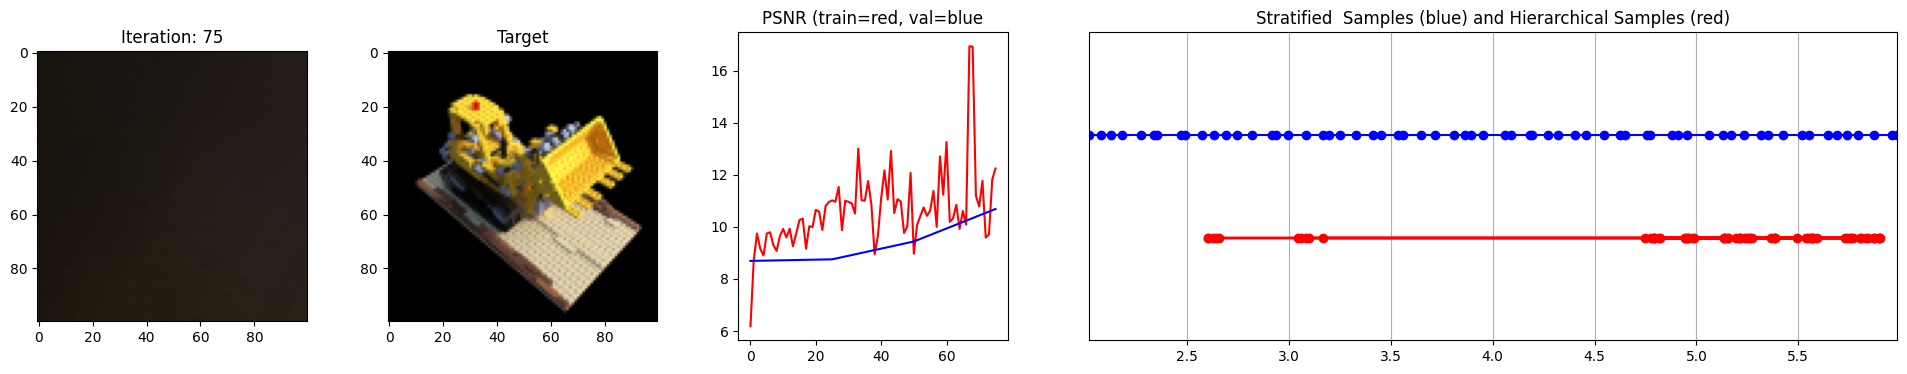

  1%|          | 100/10000 [00:33<1:10:18,  2.35it/s]

Loss: 0.07791466265916824


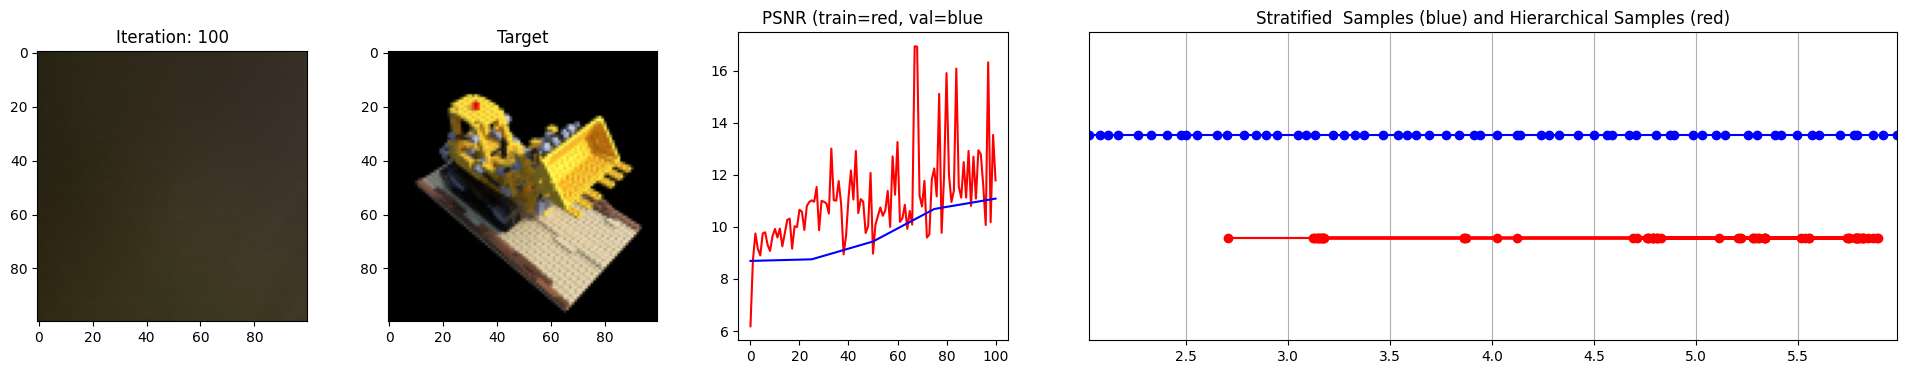

  1%|▏         | 125/10000 [00:45<1:10:35,  2.33it/s]

Loss: 0.07776574045419693


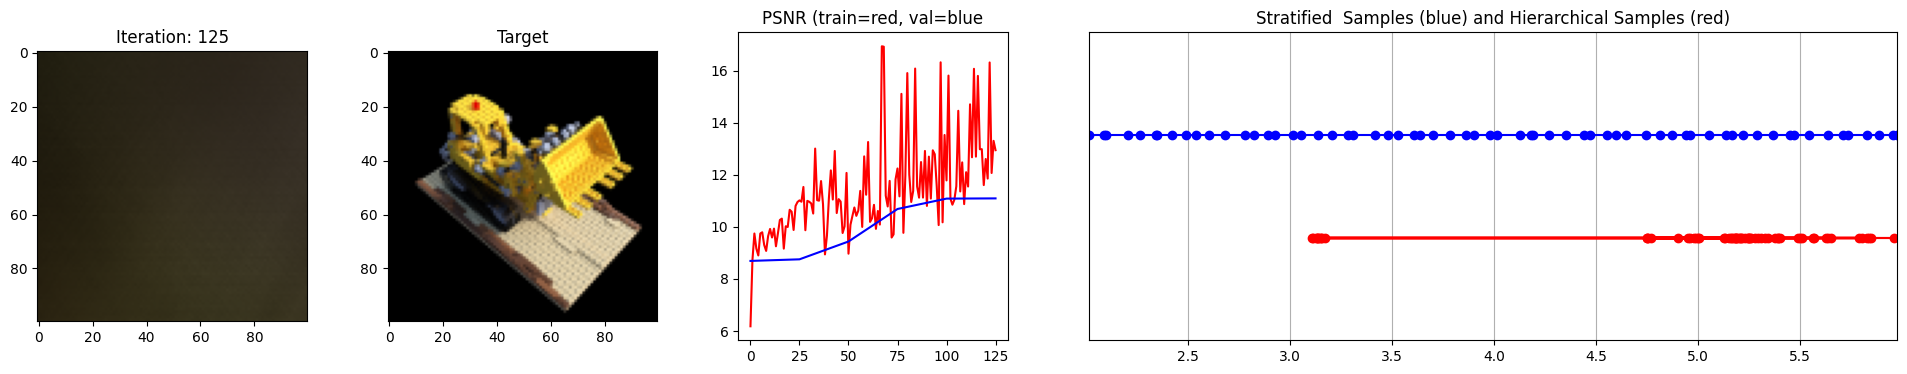

  2%|▏         | 150/10000 [00:56<1:10:32,  2.33it/s]

Loss: 0.07556644827127457


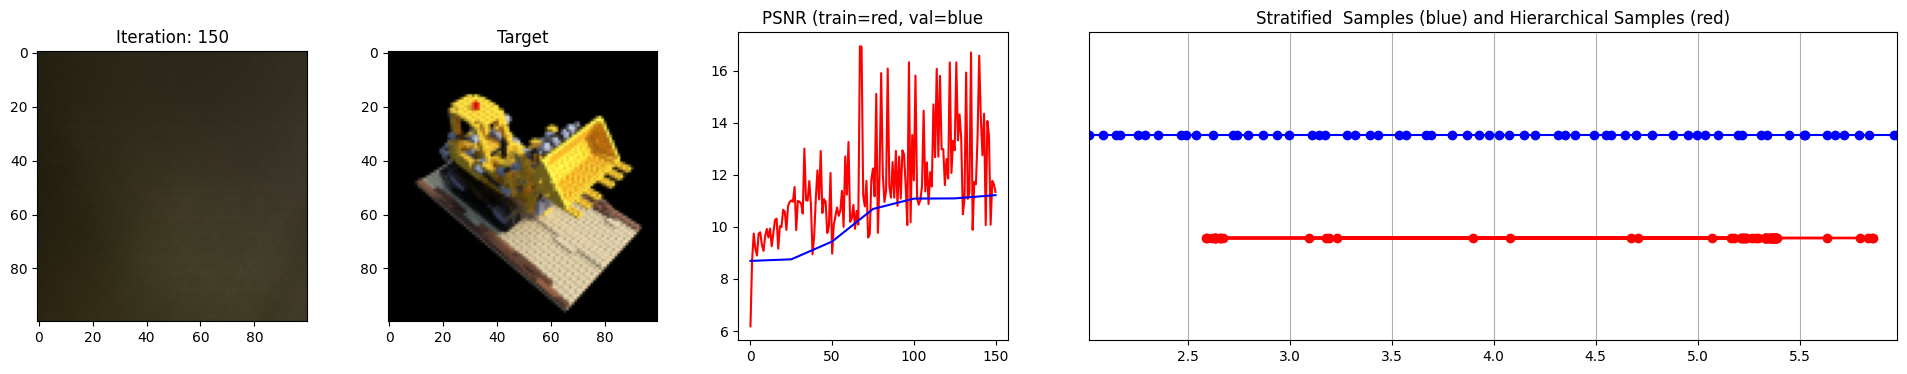

  2%|▏         | 175/10000 [01:08<1:10:28,  2.32it/s]

Loss: 0.07359767705202103


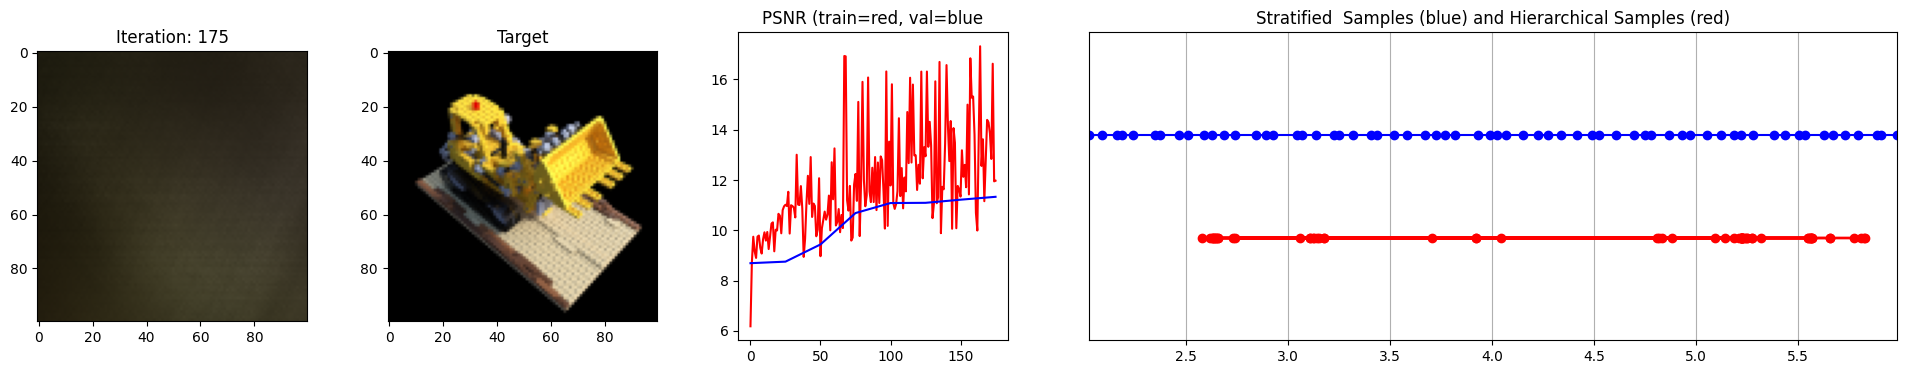

  2%|▏         | 200/10000 [01:20<1:10:39,  2.31it/s]

Loss: 0.0700388178229332


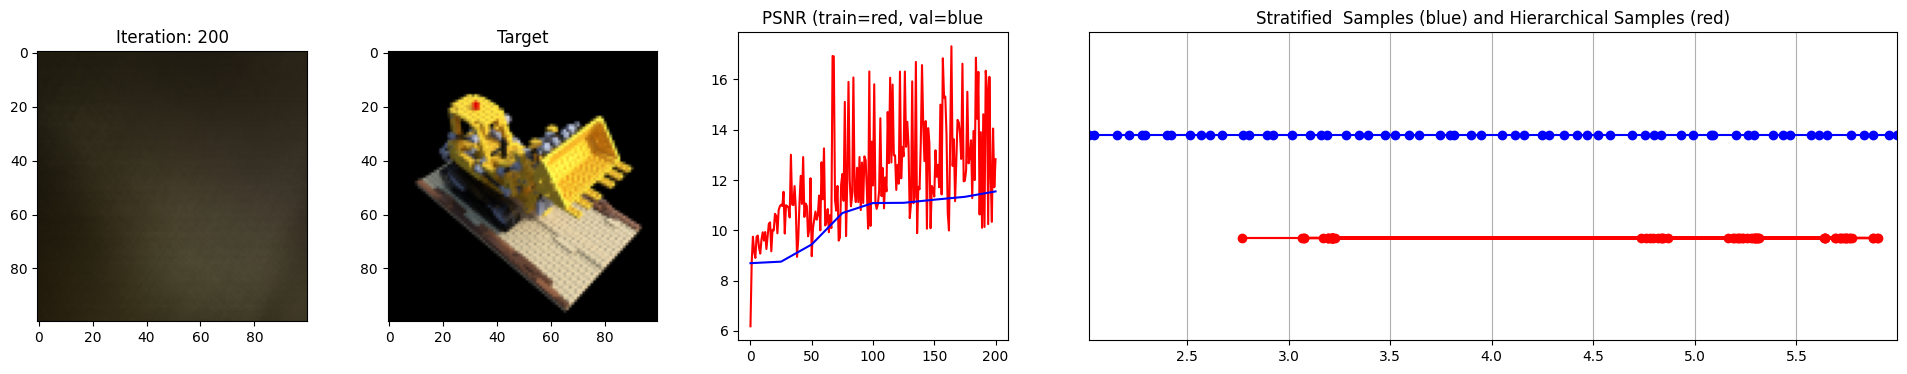

  2%|▏         | 225/10000 [01:31<1:10:44,  2.30it/s]

Loss: 0.06129089370369911


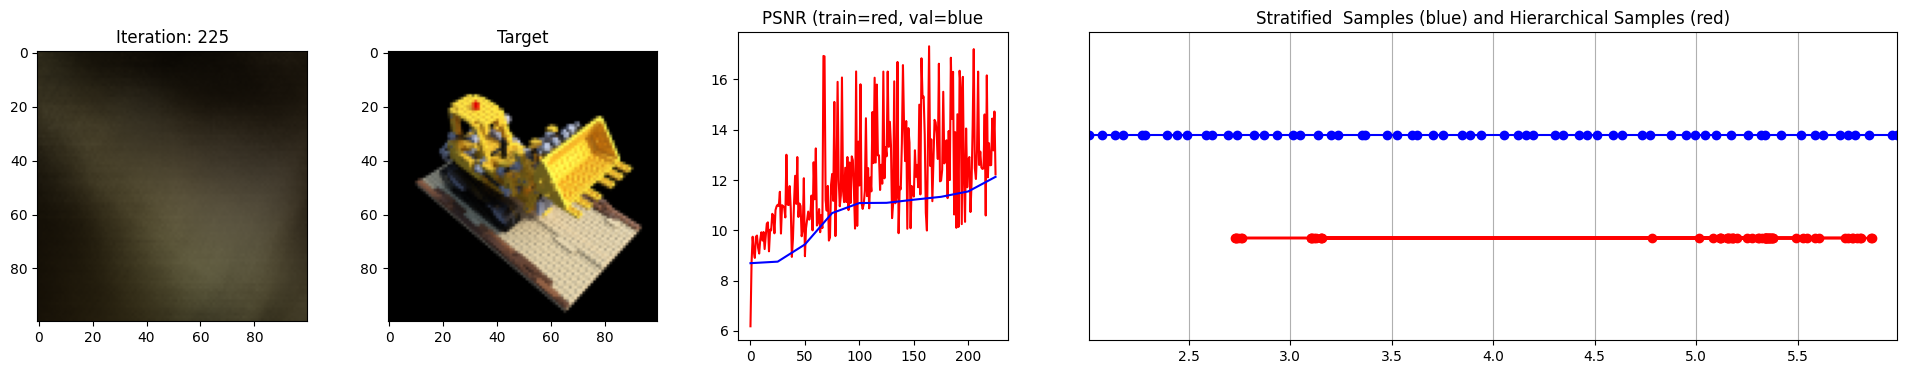

  2%|▎         | 250/10000 [01:43<1:10:42,  2.30it/s]

Loss: 0.05163468420505524


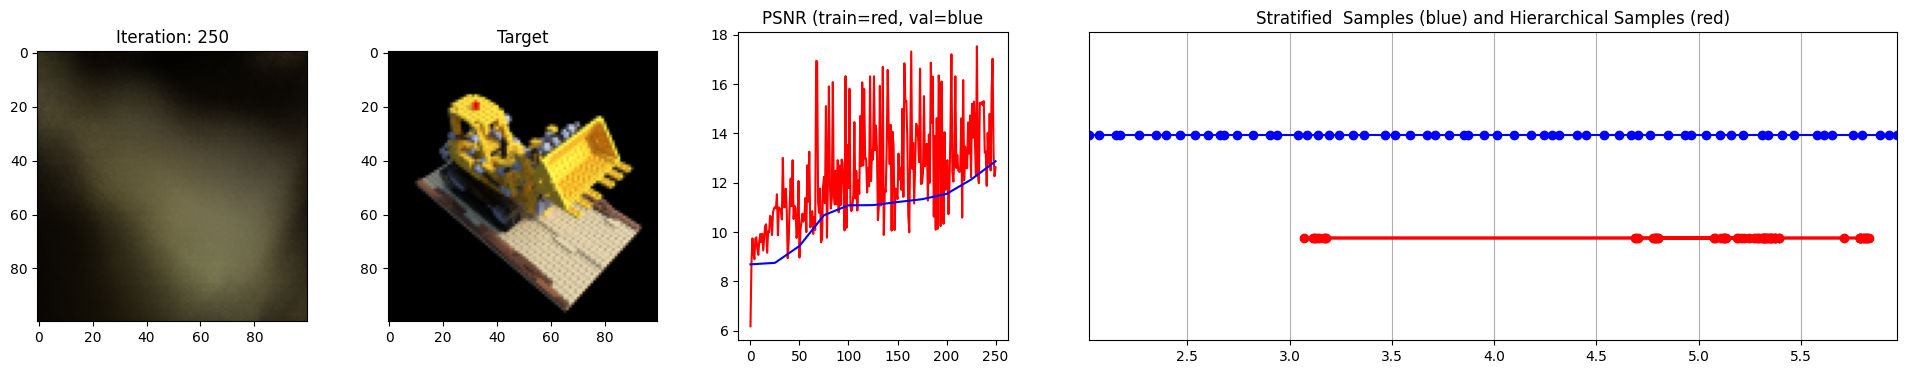

  3%|▎         | 275/10000 [01:55<1:11:02,  2.28it/s]

Loss: 0.03869786113500595


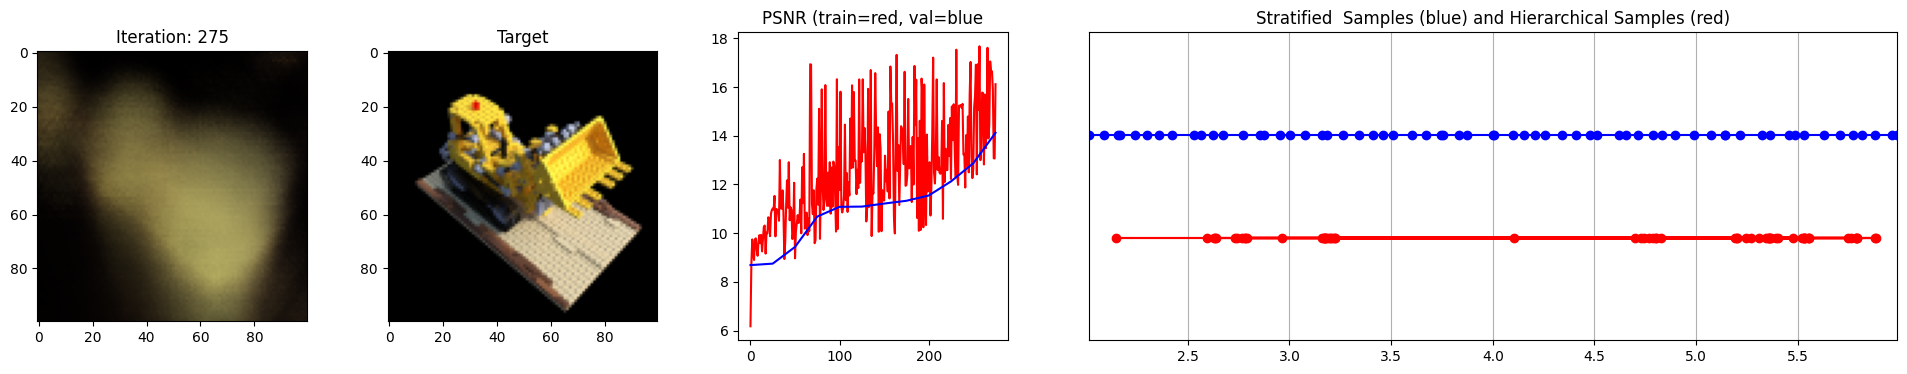

  3%|▎         | 300/10000 [02:07<1:10:36,  2.29it/s]

Loss: 0.030887208878993988


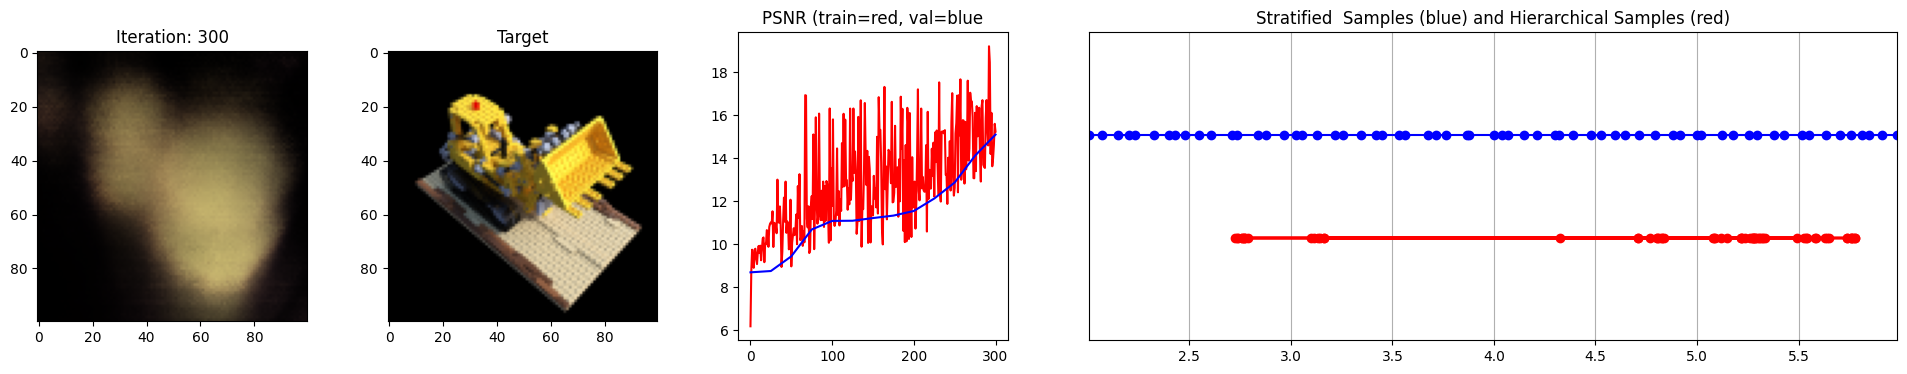

  3%|▎         | 325/10000 [02:19<1:10:32,  2.29it/s]

Loss: 0.027240270748734474


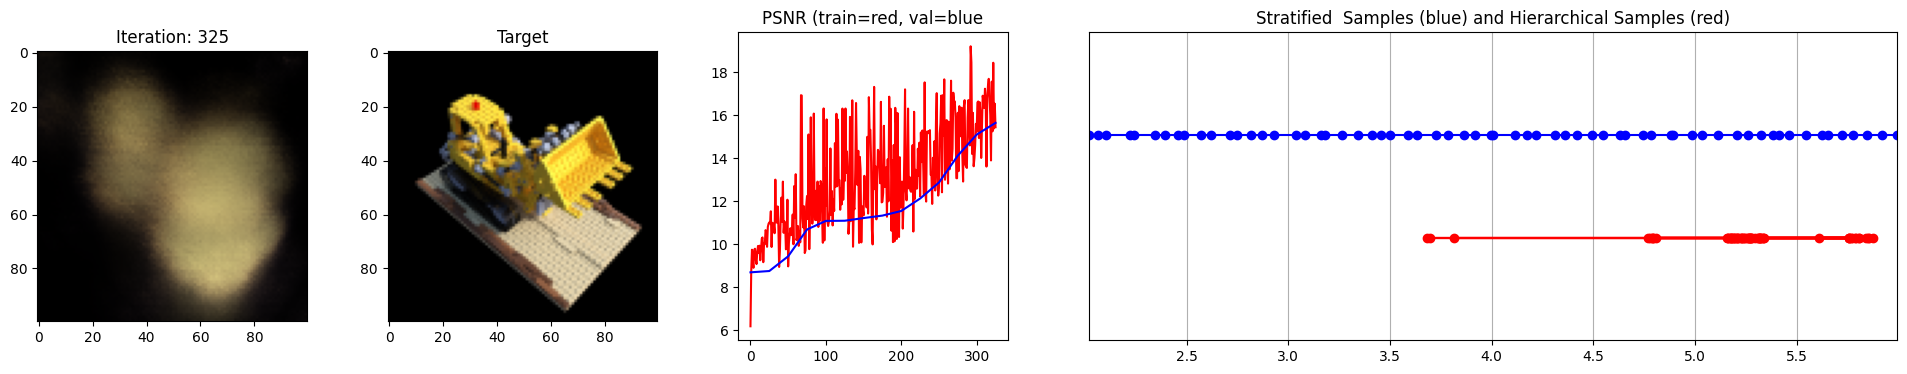

  4%|▎         | 350/10000 [02:31<1:10:24,  2.28it/s]

Loss: 0.025411318987607956


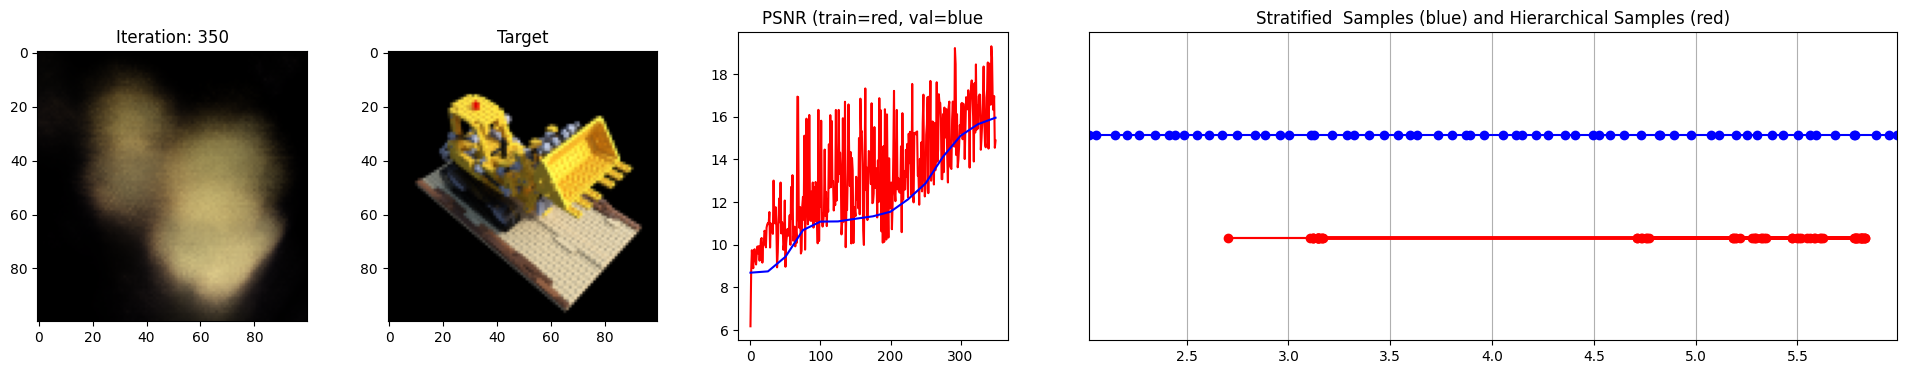

  4%|▍         | 375/10000 [02:43<1:09:59,  2.29it/s]

Loss: 0.02373325079679489


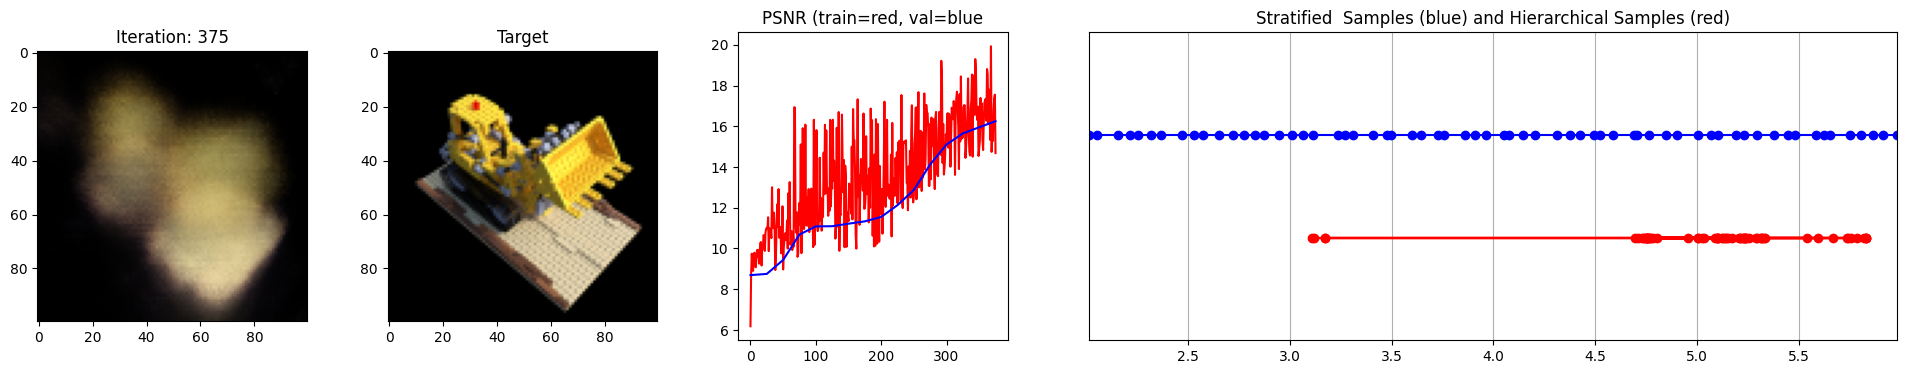

  4%|▍         | 400/10000 [02:55<1:09:34,  2.30it/s]

Loss: 0.022113515064120293


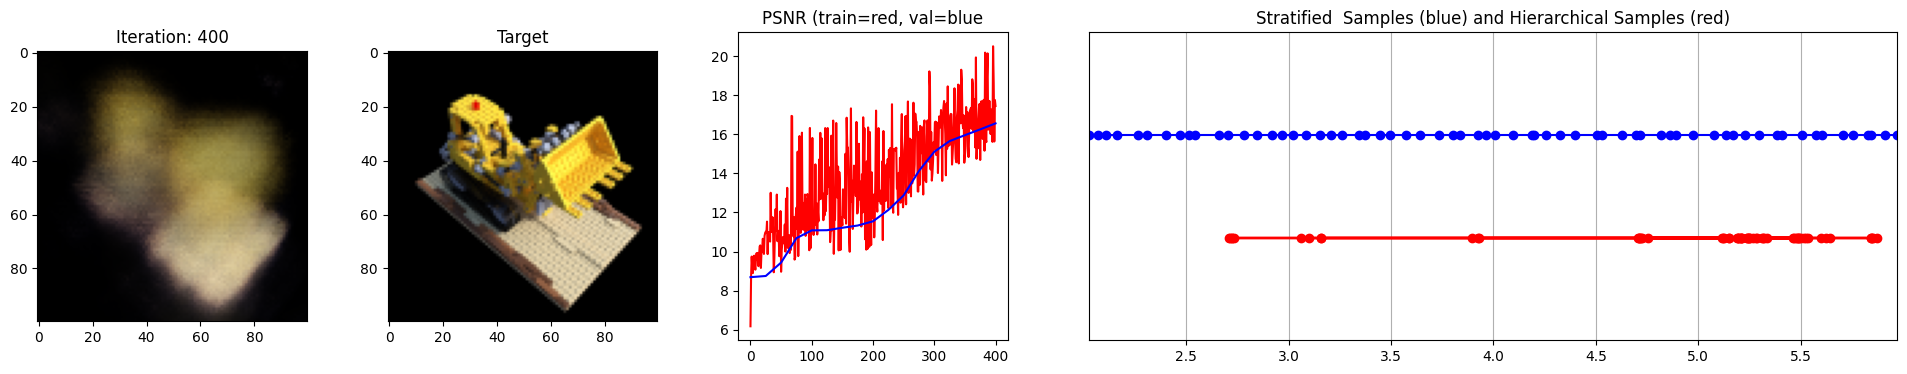

  4%|▍         | 425/10000 [03:07<1:09:38,  2.29it/s]

Loss: 0.022283650934696198


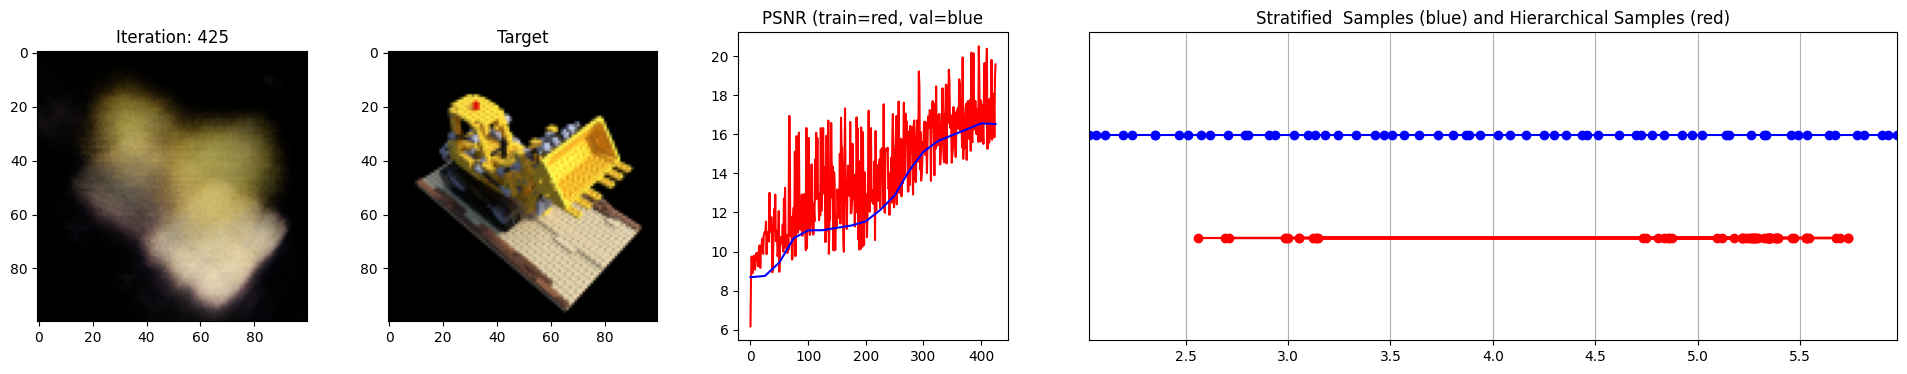

  4%|▍         | 450/10000 [03:19<1:09:20,  2.30it/s]

Loss: 0.02204357646405697


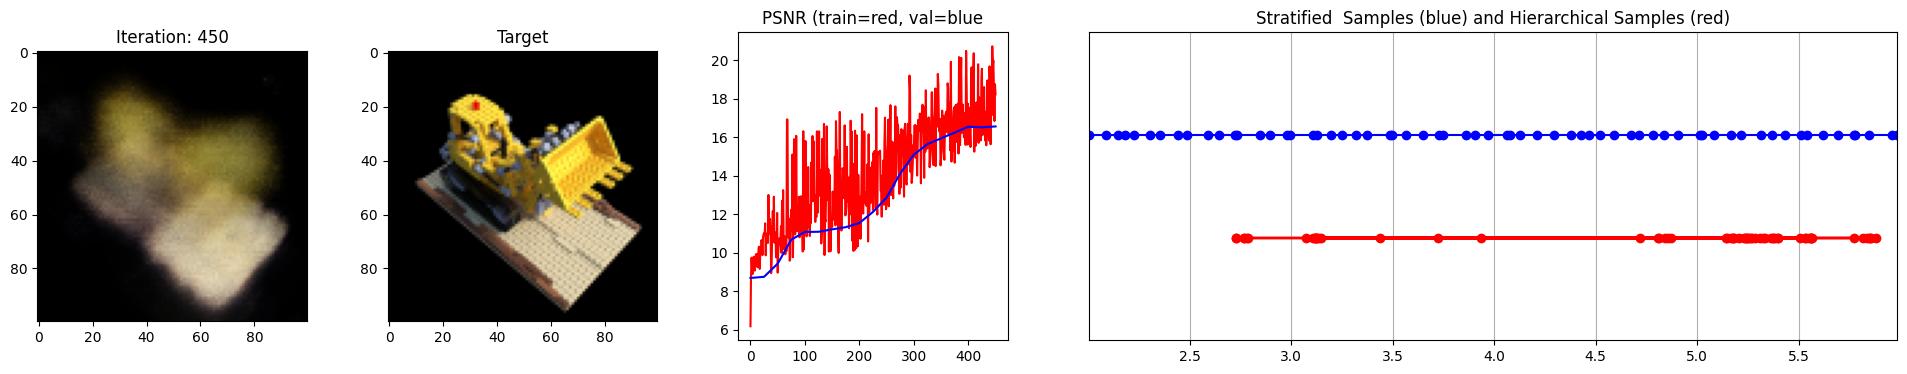

  5%|▍         | 460/10000 [03:24<1:12:02,  2.21it/s]

In [ ]:
# Run training session(s)
for _ in range(n_restarts):
  model, fine_model, encode, encode_viewdirs, optimizer, warmup_stopper = init_models()
  success, train_psnrs, val_psnrs = train()
  if success and val_psnrs[-1] >= warmup_min_fitness:
    print('Training successful!')
    break

print('')
print(f'Done!')

In [ ]:
torch.save(model.state_dict(), 'nerf.pt')
torch.save(fine_model.state_dict(), 'nerf-fine.pt')